In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Load the dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

# View the first few rows of the training data
train_data.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


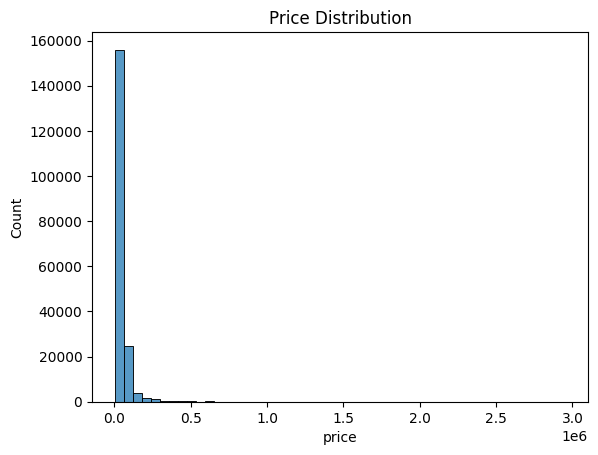

In [4]:
# Check for null values
train_data.info()

# Summary statistics
train_data.describe()

# Visualize distributions
sns.histplot(train_data['price'], bins=50)
plt.title('Price Distribution')
plt.show()

In [5]:
# View the first few rows of the dataset
print(train_data.head())

   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T  

In [6]:
# Summary statistics for numeric features
print(train_data.describe())

                  id     model_year         milage         price
count  188533.000000  188533.000000  188533.000000  1.885330e+05
mean    94266.000000    2015.829998   65705.295174  4.387802e+04
std     54424.933488       5.660967   49798.158076  7.881952e+04
min         0.000000    1974.000000     100.000000  2.000000e+03
25%     47133.000000    2013.000000   24115.000000  1.700000e+04
50%     94266.000000    2017.000000   57785.000000  3.082500e+04
75%    141399.000000    2020.000000   95400.000000  4.990000e+04
max    188532.000000    2024.000000  405000.000000  2.954083e+06


In [7]:
# Check for missing values
missing_values = train_data.isnull().sum()
print(missing_values[missing_values > 0])


fuel_type       5083
accident        2452
clean_title    21419
dtype: int64


In [8]:
# Check unique values for categorical columns
categorical_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

for col in categorical_cols:
    print(f"Unique values in {col}: {train_data[col].unique()}\n")

Unique values in brand: ['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']

Unique values in model: ['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']

Unique values in fuel_type: ['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']

Unique values in engine: ['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel'
 '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel'
 '320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability' ...

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


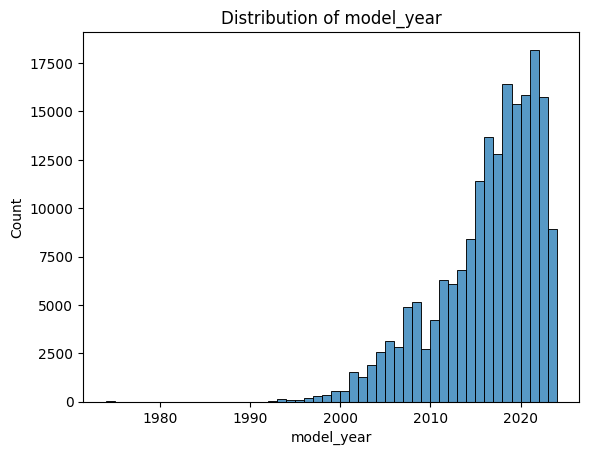

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


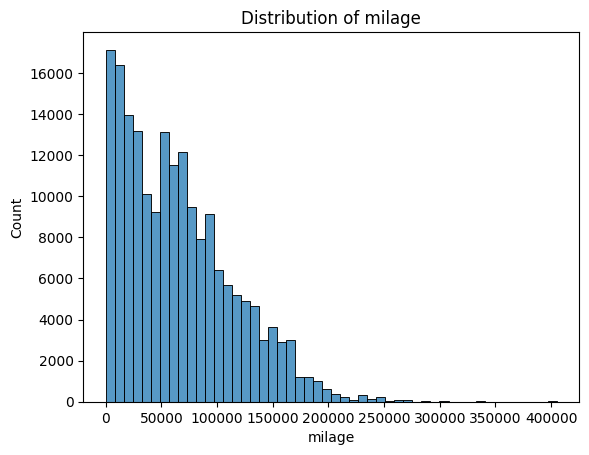

In [9]:
# Visualize distributions of numeric columns
numeric_cols = ['model_year', 'milage']

for col in numeric_cols:
    sns.histplot(train_data[col], bins=50)
    plt.title(f'Distribution of {col}')
    plt.show()

In [10]:
# Fill missing values for categorical columns
train_data['fuel_type'].fillna(train_data['fuel_type'].mode()[0], inplace=True)
train_data['accident'].fillna(train_data['accident'].mode()[0], inplace=True)
train_data['clean_title'].fillna(train_data['clean_title'].mode()[0], inplace=True)

# Alternatively, drop rows with missing values if necessary
train_data.dropna(inplace=True)

/tmp/ipykernel_17/1338501171.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['fuel_type'].fillna(train_data['fuel_type'].mode()[0], inplace=True)
/tmp/ipykernel_17/1338501171.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(

In [11]:
# One-hot encode categorical variables
train_data = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)

In [12]:
# Example: Age of the car
current_year = 2024
train_data['car_age'] = current_year - train_data['model_year']

# Example: If engine size is a string, extract the numerical part
# train_data['engine_size'] = train_data['engine'].str.extract('(\d+\.?\d*)').astype(float)

In [13]:
# Features and target variable
X = train_data.drop(['id', 'price'], axis=1)
y = train_data['price']

# Train-validation split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train[X_train_sample.index]

In [14]:
from catboost import CatBoostRegressor

# Initialize CatBoost model
catboost_model = CatBoostRegressor(iterations=100, random_seed=42, verbose=0)

# Train the model
catboost_model.fit(X_train, y_train)

In [15]:
# Predict and evaluate
y_pred_catboost = catboost_model.predict(X_test)
rmse_catboost = mean_squared_error(y_test, y_pred_catboost, squared=False)
print(f"CatBoost RMSE: {rmse_catboost}")

CatBoost RMSE: 71071.15603503608


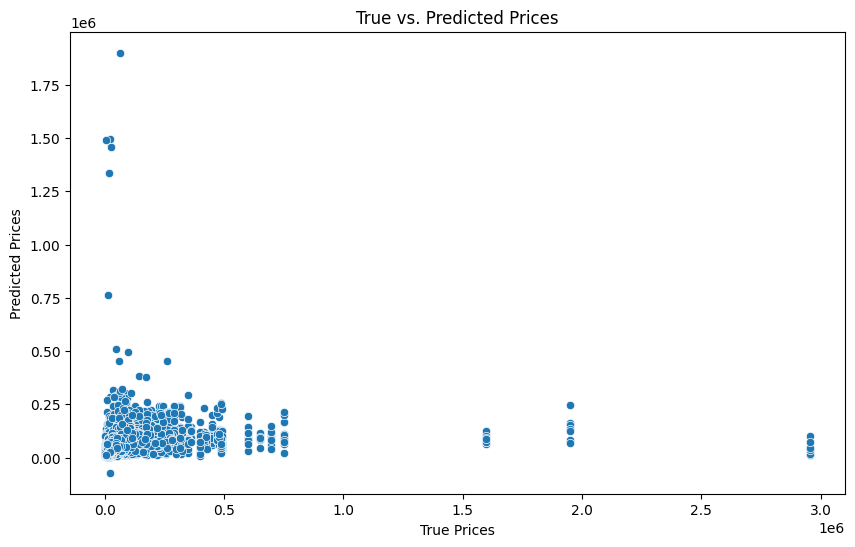

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_catboost)
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('True vs. Predicted Prices')
plt.show()

In [17]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)

# Train the model
lgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lgb = lgb_model.predict(X_test)
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)
print(f"LightGBM RMSE: {rmse_lgb}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.065229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5384
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 2533
[LightGBM] [Info] Start training from score 43890.785316
LightGBM RMSE: 68368.88648129627


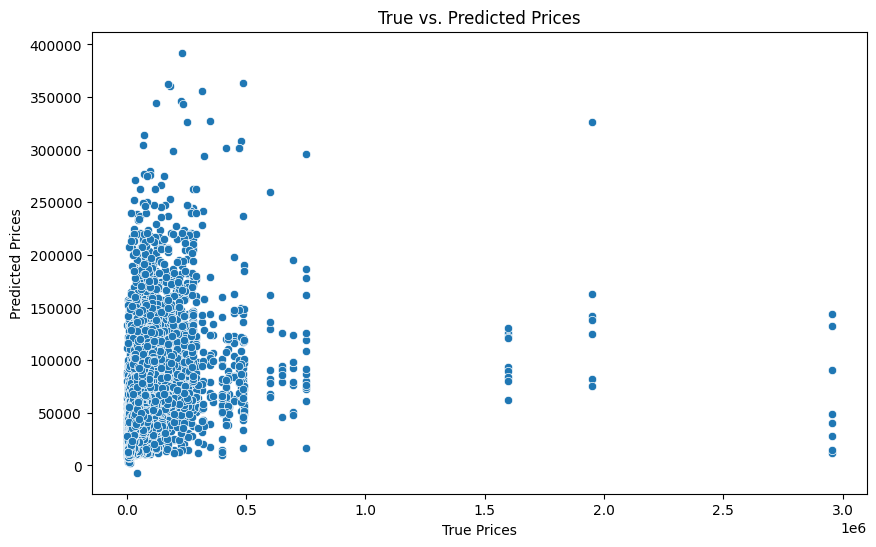

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_lgb)
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('True vs. Predicted Prices')
plt.show()